# Rate depedent 1D SLIDE model

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

### Model implementation (single material point)

In [105]:
def get_bond_slip(s_arr, dt, tau_pi_bar, K, gamma, E_b, S, c, r, m, sigma_n, eta):

    # arrays to store the values
    tau_arr = np.zeros_like(s_arr)
    w_arr = np.zeros_like(s_arr)
    s_pi_arr = np.zeros_like(s_arr)
    s_vis_arr = np.zeros_like(s_arr)
    f = np.zeros_like(s_arr)
    
    # initial state
    tau_i = 0
    alpha_i = 0.
    s_pi_i = 0
    z_i = 0.
    w_i = 0.
    s_vis_i = 0.
    s_i = 0
    
    ds_arr = s_arr[1:] - s_arr[:-1]
    

    for i, ds in enumerate(ds_arr):
        
        s_i += ds * dt
        print(s_i)
        tau_trial = (1 - w_i) * E_b * (s_i - s_pi_i)
        tau_i = tau_trial
        
        z_n = z_i
        alpha_n = alpha_i

        # Threshold
        f_pi_i = np.fabs(tau_trial/(1. - w_i) - gamma * alpha_i) - tau_pi_bar - K * z_i + m * sigma_n

        if f_pi_i > 1e-6:
            # Return mapping
            delta_lamda = f_pi_i / (E_b / (1. - w_i) + gamma + K)
            # update all the state variables
            s_pi_i +=  delta_lamda * np.sign(tau_trial/(1. - w_i) - gamma * alpha_i) / (1 - w_i)
            Y_i = 0.5 * E_b * (s_i - s_pi_i) ** 2
            w_i += ((1. - w_i) ** c) * (delta_lamda * (Y_i / S) ** r)  * (1 - sigma_n / (0.5 * tau_pi_bar)) 
            alpha_i += delta_lamda * np.sign(tau_trial/(1. - w_i) - gamma * alpha_i)
            z_i +=  delta_lamda
            tau_i = E_b * (1. - w_i) * (s_i - s_pi_i)
            
            
           # perform viscoplastic regularization
            relax_t = eta / (E_b + K + gamma)
             
            tau_i = (tau_trial + (dt/relax_t) * tau_i)/(1. + dt/relax_t)  
            z_i = (z_n + (dt/relax_t) * z_i)/(1. + dt/relax_t) 
            alpha_i = (alpha_n + (dt/relax_t) * alpha_i)/(1. + dt/relax_t) 
            s_vis_i = s_i - tau_i/E_b

        i1 = i+1
        tau_arr[i1] = tau_i
        w_arr[i1] = w_i
        s_pi_arr[i1] = s_pi_i
        s_vis_arr[i1] = s_vis_i

    return s_arr, tau_arr, w_arr, s_pi_arr, s_vis_arr


### Apply loading

In [106]:
# Define the loading values

Number_of_cycles = 1
maximum_slip = 0.5


number_of_increments_1 = 10
number_of_increments_2 = 10
number_of_increments_3 = 10


# Construction of the loading history
s_levels = np.linspace(0, maximum_slip, 2 * Number_of_cycles )
s_levels[0] = 0
s_levels.reshape(-1, 2)[:, 0] *= -1
s_history = s_levels.flatten()





# slip array as input
s_arr_1 = np.hstack([np.linspace(s_history[i], s_history[i + 1], number_of_increments_1)
                     for i in range(len(s_levels) - 1)])

s_arr_2 = np.hstack([np.linspace(s_history[i], s_history[i + 1], number_of_increments_2)
                     for i in range(len(s_levels) - 1)])

s_arr_3 = np.hstack([np.linspace(s_history[i], s_history[i + 1], number_of_increments_3)
                     for i in range(len(s_levels) - 1)])



# material parameters
tau_pi_bar=1
K=0
gamma=0
E_b=10
S=100000.0005
c=1
r=1.0
m=0.0
sigma_n=0
eta = 1

dt_1 = 1./number_of_increments_1
dt_2 = 1./number_of_increments_2
dt_3 = 1./number_of_increments_3


#dt_1 = sim_time_1 /number_of_increments
#dt_2 = sim_time_2 /number_of_increments
#dt_3 = sim_time_3 /number_of_increments


# Runing the simulation
s_arr_1,  tau_arr_1, w_arr_1, s_pi_arr_1, s_vis_arr_1 = get_bond_slip(
    s_arr_1, dt_1,tau_pi_bar=tau_pi_bar, K=K, gamma=gamma, E_b=E_b, S=S, c=c, r=r, m=m, sigma_n=sigma_n, eta= eta)


s_arr_2,  tau_arr_2, w_arr_2, s_pi_arr_2, s_vis_arr_2 = get_bond_slip(
    s_arr_2, dt_2,tau_pi_bar=tau_pi_bar, K=K, gamma=gamma, E_b=E_b, S=S, c=c, r=r, m=m, sigma_n=sigma_n, eta= eta*1000)


s_arr_3,  tau_arr_3, w_arr_3, s_pi_arr_3, s_vis_arr_3 = get_bond_slip(
    s_arr_3, dt_3,tau_pi_bar=tau_pi_bar, K=K, gamma=gamma, E_b=E_b, S=S, c=c, r=r, m=m, sigma_n=sigma_n, eta= eta/1000)

0.005555555555555556
0.011111111111111112
0.016666666666666666
0.022222222222222223
0.027777777777777783
0.03333333333333334
0.03888888888888889
0.044444444444444446
0.05
0.005555555555555556
0.011111111111111112
0.016666666666666666
0.022222222222222223
0.027777777777777783
0.03333333333333334
0.03888888888888889
0.044444444444444446
0.05
0.005555555555555556
0.011111111111111112
0.016666666666666666
0.022222222222222223
0.027777777777777783
0.03333333333333334
0.03888888888888889
0.044444444444444446
0.05


### Plotting

<IPython.core.display.Javascript object>


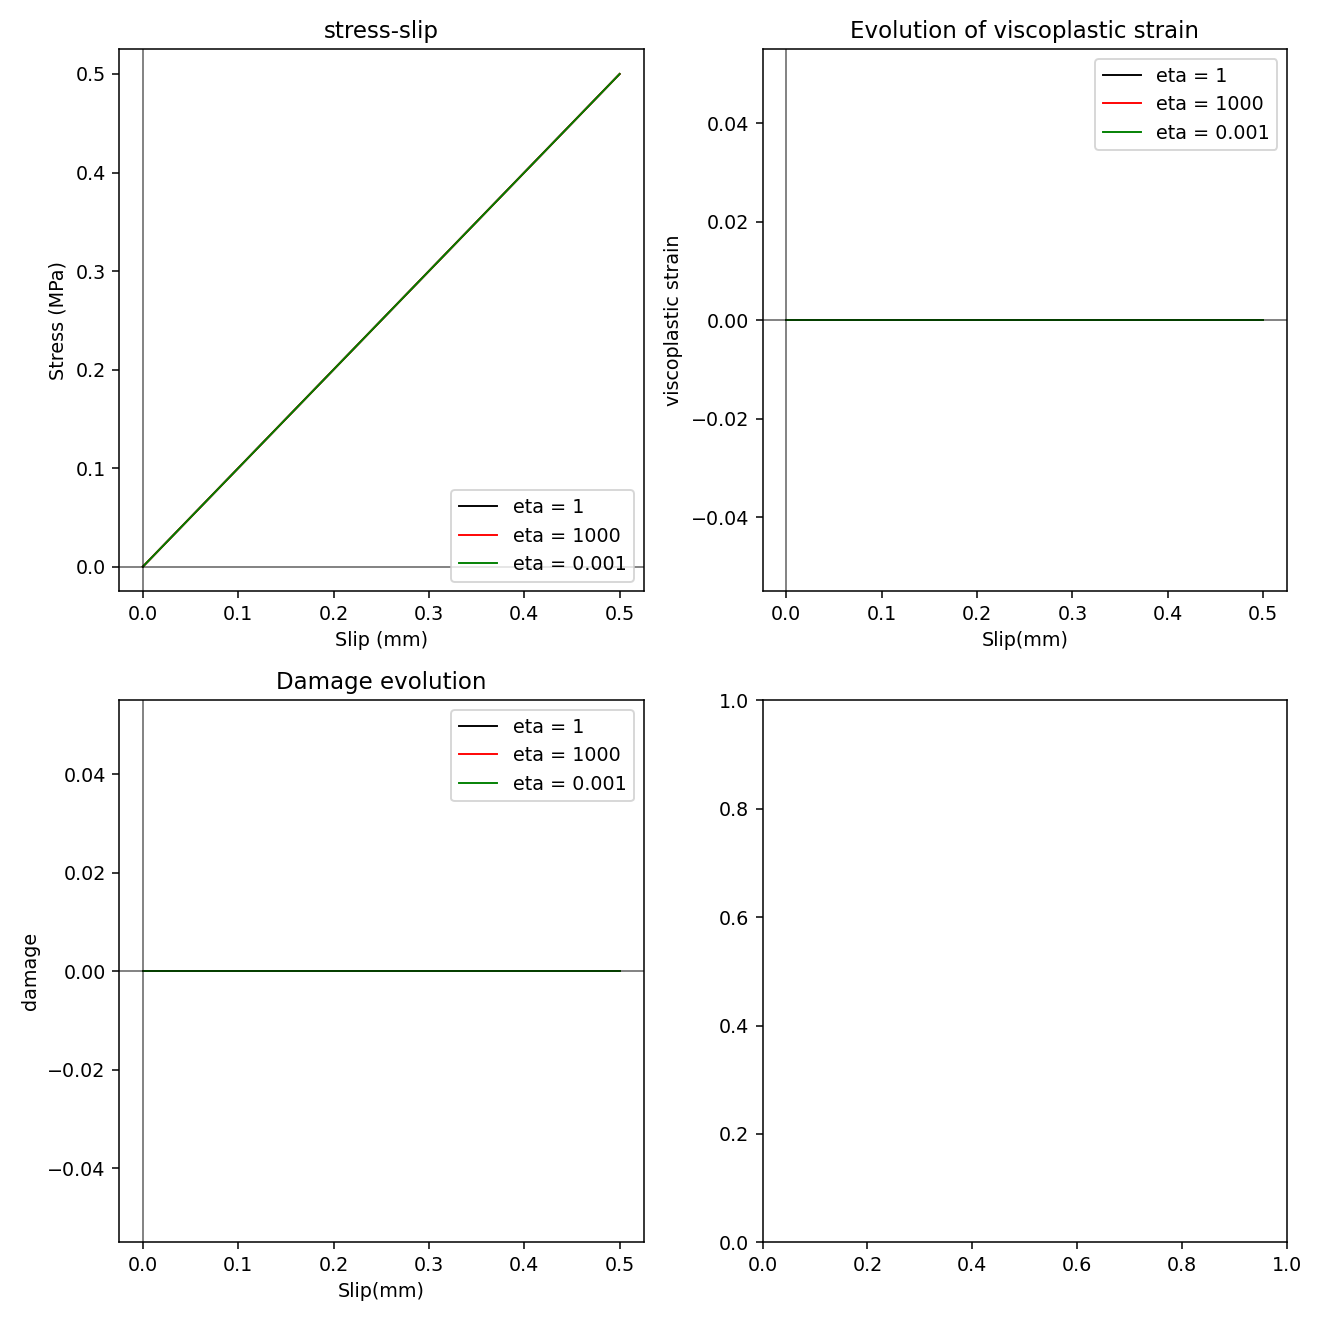

In [104]:
import matplotlib.pylab as plt
fig, ((ax_1,  ax_2), (ax_3,  ax_4)) = plt.subplots(2,2, tight_layout=True, figsize=(7,7))
fig.canvas.header_visible=False


ax1 = plt.subplot(221)
ax1.plot(s_arr_1, tau_arr_1, 'k', linewidth=1, label="eta = 1")
ax1.plot(s_arr_2, tau_arr_2, 'r', linewidth=1, label="eta = 1000")
ax1.plot(s_arr_3, tau_arr_3, 'g', linewidth=1, label="eta = 0.001")
ax1.axhline(y=0, color='k', linewidth=1, alpha=0.5)
ax1.axvline(x=0, color='k', linewidth=1, alpha=0.5)
plt.title('stress-slip')
plt.xlabel('Slip (mm)')
plt.ylabel('Stress (MPa)')
plt.legend(loc=4)


ax2 = plt.subplot(222)
ax2.plot(s_arr_1, s_vis_arr_1, 'k', linewidth=1, label="eta = 1")
ax2.plot(s_arr_2, s_vis_arr_2, 'r', linewidth=1, label="eta = 1000")
ax2.plot(s_arr_3, s_vis_arr_3, 'g', linewidth=1, label="eta = 0.001")
ax2.axhline(y=0, color='k', linewidth=1, alpha=0.5)
ax2.axvline(x=0, color='k', linewidth=1, alpha=0.5)
plt.title('Evolution of viscoplastic strain')
plt.xlabel('Slip(mm)')
plt.ylabel('viscoplastic strain')
plt.legend()
 

ax3 = plt.subplot(223)
ax3.plot(s_arr_1, w_arr_1, 'k', linewidth=1, label="eta = 1")
ax3.plot(s_arr_2, w_arr_2, 'r', linewidth=1, label="eta = 1000")
ax3.plot(s_arr_3, w_arr_3, 'g', linewidth=1, label="eta = 0.001")
ax3.axhline(y=0, color='k', linewidth=1, alpha=0.5)
ax3.axvline(x=0, color='k', linewidth=1, alpha=0.5)
plt.title('Damage evolution')
plt.xlabel('Slip(mm)')
plt.ylabel('damage')
plt.legend()

plt.show()